In [ ]:
import pandas as pd
import numpy as np
import os
import string
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from collections import Counter
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import GridSearchCV
%matplotlib inline

https://www.kaggle.com/datasets/venky73/spam-mails-dataset[link text](https:// [link text](https://))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/Email_Classification"

In [ ]:
os.chdir(path)

In [ ]:
os.listdir()

['spam_ham_dataset.csv']

Data  Exploration

In [ ]:
df = pd.read_csv('spam_ham_dataset.csv')

In [ ]:
df.shape

(5171, 4)

In [ ]:
df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [ ]:
# dropping columns Unnamed: 0 and label_num because these columns wouldn't be useful for us(for identifying spam or ham)
email_df = df.drop(['Unnamed: 0', "label_num"], axis = 1)

Separating subject and body

In [ ]:
def get_email_subject(email):
    subject = email[0:email.find('\r\n')]
    subject = subject. replace('Subject: ', '')
    return subject

def get_email_body(email):
    body = email[email.find('\r\n')+2:]
    return body

In [ ]:
# get the subject and body of email
email_df["subject"] = email_df["text"].apply(lambda x: get_email_subject(x))
email_df["body"] = email_df["text"].apply(lambda x: get_email_body(x))

In [ ]:
email_df

,label,text,subject,body
0,ham,Subject: enron methanol ; meter # : 988291\r\n...,enron methanol ; meter # : 988291,this is a follow up to the note i gave you on ...
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...","hpl nom for january 9 , 2001",( see attached file : hplnol 09 . xls )\r\n- h...
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",neon retreat,"ho ho ho , we ' re around to that most wonderf..."
3,spam,"Subject: photoshop , windows , office . cheap ...","photoshop , windows , office . cheap . main tr...",abasements darer prudently fortuitous undergon...
4,ham,Subject: re : indian springs\r\nthis deal is t...,re : indian springs,this deal is to book the teco pvr revenue . it...
...,...,...,...,...
5166,ham,Subject: put the 10 on the ft\r\nthe transport...,put the 10 on the ft,the transport volumes decreased from 25000 to ...
5167,ham,Subject: 3 / 4 / 2000 and following noms\r\nhp...,3 / 4 / 2000 and following noms,hpl can ' t take the extra 15 mmcf / d over th...
5168,ham,Subject: calpine daily gas nomination\r\n>\r\n...,calpine daily gas nomination,">\r\n>\r\njulie , as i mention earlier we hope..."
5169,ham,Subject: industrial worksheets for august 2000...,industrial worksheets for august 2000 activity,attached are the worksheets for august 2000 ac...


In [ ]:
# Removing text after separating subject and body
email_df = email_df.drop(["text"], axis = 1)

In [ ]:
# expand default pandas display options to make emails more clearly visible when printed
pd.set_option('display.max_colwidth', 100)

In [ ]:
email_df.head()

,label,subject,body
0,ham,enron methanol ; meter # : 988291,"this is a follow up to the note i gave you on monday , 4 / 3 / 00 { preliminary\r\nflow data pro..."
1,ham,"hpl nom for january 9 , 2001",( see attached file : hplnol 09 . xls )\r\n- hplnol 09 . xls
2,ham,neon retreat,"ho ho ho , we ' re around to that most wonderful time of the year - - - neon leaders retreat tim..."
3,spam,"photoshop , windows , office . cheap . main trending",abasements darer prudently fortuitous undergone\r\nlighthearted charm orinoco taster\r\nrailroad...
4,ham,re : indian springs,this deal is to book the teco pvr revenue . it is my understanding that teco\r\njust sends us a ...


In [ ]:
email_df.shape

(5171, 3)

Text Pre-processing 

In [ ]:
import re

import nltk
nltk.download('punkt')

from nltk.tokenize import word_tokenize

nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))

#stop_words.extend(['crypto','even','early'])

import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
def text_cleaner(review):
  # removing the not required texts
  cleaned_review = re.sub(re.compile('<.*?>'), '', review) #removing HTML tags
  cleaned_review = re.sub('[^A-Za-z]+', ' ', cleaned_review) #taking only words
  cleaned_review = re.sub(r'[\r\n]',"", cleaned_review) 
  cleaned_review = cleaned_review.lower()

  tokens = nltk.word_tokenize(cleaned_review)

  filtered_review = [word for word in tokens if word not in stop_words] # removing stop words

  lemm_review = [lemmatizer.lemmatize(word) for word in filtered_review]
  # review = " ".join(lemm_review)
  return(lemm_review)

In [ ]:
clean_email = pd.DataFrame(email_df,columns=['label'])

In [ ]:
cleanText_Sub=[]

for t in email_df['subject']:
 cleanText_Sub.append(text_cleaner(t))

clean_email["clean_Sub"] = cleanText_Sub
clean_email.head()

,label,clean_Sub
0,ham,"[enron, methanol, meter]"
1,ham,"[hpl, nom, january]"
2,ham,"[neon, retreat]"
3,spam,"[photoshop, window, office, cheap, main, trending]"
4,ham,"[indian, spring]"


In [ ]:
cleanText_Body=[]

for t in email_df['body']:
 cleanText_Body.append(text_cleaner(t))

clean_email["clean_Body"] = cleanText_Body
clean_email.head()

,label,clean_Sub,clean_Body
0,ham,"[enron, methanol, meter]","[follow, note, gave, monday, preliminary, flow, data, provided, daren, please, override, pop, da..."
1,ham,"[hpl, nom, january]","[see, attached, file, hplnol, xl, hplnol, xl]"
2,ham,"[neon, retreat]","[ho, ho, ho, around, wonderful, time, year, neon, leader, retreat, time, know, time, year, extre..."
3,spam,"[photoshop, window, office, cheap, main, trending]","[abasement, darer, prudently, fortuitous, undergone, lighthearted, charm, orinoco, taster, railr..."
4,ham,"[indian, spring]","[deal, book, teco, pvr, revenue, understanding, teco, sends, u, check, received, answer, whether..."


In [ ]:
clean_email["Sub_length"] = clean_email["clean_Sub"].apply(len)

In [ ]:
clean_email["Body_length"] = clean_email["clean_Body"].apply(len)

In [ ]:
clean_email.head()

,label,clean_Sub,clean_Body,Sub_length,Body_length
0,ham,"[enron, methanol, meter]","[follow, note, gave, monday, preliminary, flow, data, provided, daren, please, override, pop, da...",3,27
1,ham,"[hpl, nom, january]","[see, attached, file, hplnol, xl, hplnol, xl]",3,7
2,ham,"[neon, retreat]","[ho, ho, ho, around, wonderful, time, year, neon, leader, retreat, time, know, time, year, extre...",2,208
3,spam,"[photoshop, window, office, cheap, main, trending]","[abasement, darer, prudently, fortuitous, undergone, lighthearted, charm, orinoco, taster, railr...",6,37
4,ham,"[indian, spring]","[deal, book, teco, pvr, revenue, understanding, teco, sends, u, check, received, answer, whether...",2,26


In [ ]:
clean_email.shape

(5171, 5)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fae19ecb690>,
      dtype=object)

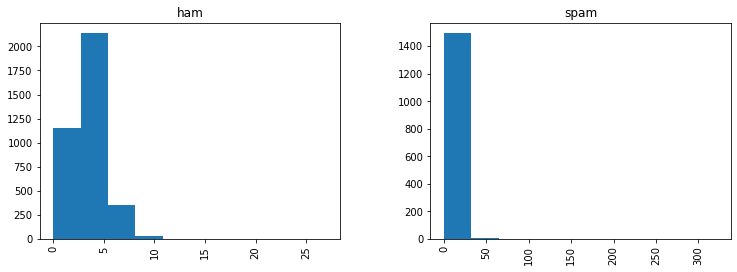

In [ ]:
clean_email.hist(column = 'Sub_length', by ='label',figsize=(12,4))#, bins =5)

Most number of HAM emails have atmost  50 characters or slightly more and highest number of characters goes till 175. Whereas in case of SPAM, most of the emails have characters till 250 in the subject line itself. The highest goes beyond 2000. 
In the SPAM mail subject line, the total number of characters is more than the total number of characters in HAM mail.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fae19d3fbd0>,
      dtype=object)

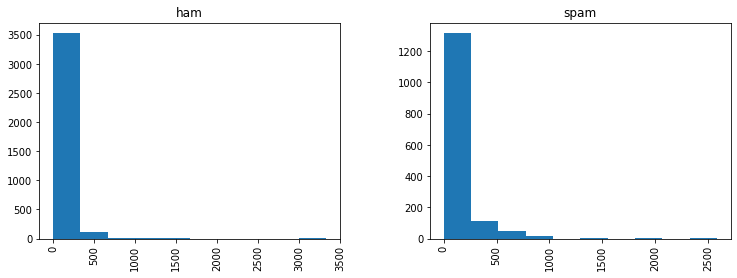

In [ ]:
clean_email.hist(column = 'Body_length', by ='label',figsize=(12,4))#, bins = 10)

Most number of HAM emails have atmost  2500 characters or slightly more and highest number of characters goes till 7500. Whereas in case of SPAM, most of the emails have characters till 5000 or more.
In the SPAM mail, the total number of characters is more than the total number of characters in HAM mail.

***Vectorization***

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
vectorization = CountVectorizer(analyzer = text_cleaner)
X = vectorization.fit(email_df['subject'])

In [ ]:
X_transform = X.transform(email_df['subject'])
print(X_transform)

  (0, 1207)	1
  (0, 2289)	1
  (0, 2290)	1
  (1, 1730)	1
  (1, 1923)	1
  (1, 2475)	1
  (2, 2438)	1
  (2, 3084)	1
  (3, 591)	1
  (3, 2178)	1
  (3, 2535)	1
  (3, 2722)	1
  (3, 3721)	1
  (3, 3995)	1
  (4, 1821)	1
  (4, 3424)	1
  (5, 46)	1
  (5, 573)	1
  (5, 1153)	1
  (5, 3957)	1
  (6, 568)	1
  (6, 3208)	1
  (6, 3424)	1
  (6, 3570)	1
  (7, 363)	1
  :	:
  (5164, 3350)	1
  (5164, 3940)	1
  (5165, 843)	1
  (5165, 1081)	1
  (5165, 1193)	1
  (5165, 1481)	1
  (5165, 2289)	1
  (5165, 2470)	1
  (5165, 2952)	1
  (5166, 1462)	1
  (5166, 2911)	1
  (5167, 1416)	1
  (5167, 2480)	1
  (5168, 497)	1
  (5168, 886)	1
  (5168, 1501)	1
  (5168, 2479)	1
  (5169, 33)	1
  (5169, 265)	1
  (5169, 1823)	1
  (5169, 4031)	1
  (5170, 105)	1
  (5170, 312)	1
  (5170, 1795)	1
  (5170, 2554)	1


In [ ]:
vectorization1 = CountVectorizer(analyzer = text_cleaner)
X1 = vectorization1.fit(email_df['body'])

In [ ]:
X_transform1 = X1.transform(email_df['body'])
print(X_transform1)

  (0, 412)	1
  (0, 2367)	1
  (0, 6738)	1
  (0, 8588)	1
  (0, 9689)	2
  (0, 9783)	1
  (0, 9838)	1
  (0, 12265)	1
  (0, 14916)	1
  (0, 15020)	1
  (0, 15821)	1
  (0, 15871)	1
  (0, 25209)	1
  (0, 26058)	1
  (0, 26613)	1
  (0, 26929)	1
  (0, 27789)	1
  (0, 29229)	1
  (0, 29473)	1
  (0, 29810)	1
  (0, 29866)	1
  (0, 30294)	1
  (0, 30518)	1
  (0, 31617)	1
  (0, 40114)	1
  :	:
  (5170, 26057)	1
  (5170, 26568)	1
  (5170, 26613)	1
  (5170, 27287)	1
  (5170, 27308)	5
  (5170, 28155)	1
  (5170, 29229)	2
  (5170, 30028)	1
  (5170, 30251)	1
  (5170, 31472)	4
  (5170, 31557)	1
  (5170, 31894)	1
  (5170, 32160)	1
  (5170, 32988)	1
  (5170, 33133)	1
  (5170, 33928)	1
  (5170, 34007)	2
  (5170, 36455)	1
  (5170, 36789)	1
  (5170, 37314)	1
  (5170, 37630)	1
  (5170, 39152)	1
  (5170, 39503)	1
  (5170, 40419)	1
  (5170, 40587)	1


***TF-IDF***

In [ ]:
tfidf_transformer = TfidfTransformer().fit(X_transform)

In [ ]:
X_tfidf = tfidf_transformer.transform(X_transform)
print(X_tfidf.shape)

(5171, 4123)


In [ ]:
tfidf_transformer1 = TfidfTransformer().fit(X_transform1)

In [ ]:
X_tfidf1 = tfidf_transformer1.transform(X_transform1)
print(X_tfidf1.shape)

(5171, 42525)


***Classification Model***

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, clean_email['label'], test_size=0.30, random_state = 50)    
clf = SVC(kernel='linear').fit(X_train, y_train)

In [ ]:
predictions = clf.predict(X_test)
print('predicted', predictions)

predicted ['ham' 'ham' 'ham' ... 'ham' 'ham' 'spam']


In [ ]:
from sklearn.metrics import classification_report
print (classification_report(y_test, predictions))

              precision    recall  f1-score   support

         ham       0.95      0.94      0.95      1103
        spam       0.85      0.89      0.87       449

    accuracy                           0.92      1552
   macro avg       0.90      0.91      0.91      1552
weighted avg       0.92      0.92      0.92      1552



As our accuracy is 92% and our F1-scores are quite good. So,  we can say that our model is rightly able to classify whether our email is SPAM or not with the subject line only. 

In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test,predictions))

[[1033   70]
 [  50  399]]


In [ ]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_tfidf1, clean_email['label'], test_size=0.30, random_state = 50)    
clf1 = SVC(kernel='linear').fit(X_train1, y_train1)

In [ ]:
predictions1 = clf1.predict(X_test1)
print('predicted', predictions1)

predicted ['ham' 'ham' 'ham' ... 'ham' 'ham' 'spam']


In [ ]:
from sklearn.metrics import classification_report
print (classification_report(y_test1, predictions1))

              precision    recall  f1-score   support

         ham       0.99      0.98      0.99      1103
        spam       0.95      0.99      0.97       449

    accuracy                           0.98      1552
   macro avg       0.97      0.98      0.98      1552
weighted avg       0.98      0.98      0.98      1552



In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test1,predictions1))

[[1078   25]
 [   6  443]]


Topic Modeling

In [ ]:
X_train

<3619x4123 sparse matrix of type '<class 'numpy.float64'>'
	with 13058 stored elements in Compressed Sparse Row format>

In [ ]:
predictionsx = clf.predict(X_tfidf)

In [ ]:
clean_email['sub_Pred'] = predictionsx

In [ ]:
clean_email.head()

,label,clean_Sub,clean_Body,Sub_length,Body_length,sub_Pred
0,ham,"[enron, methanol, meter]","[follow, note, gave, monday, preliminary, flow, data, provided, daren, please, override, pop, da...",3,27,ham
1,ham,"[hpl, nom, january]","[see, attached, file, hplnol, xl, hplnol, xl]",3,7,ham
2,ham,"[neon, retreat]","[ho, ho, ho, around, wonderful, time, year, neon, leader, retreat, time, know, time, year, extre...",2,208,ham
3,spam,"[photoshop, window, office, cheap, main, trending]","[abasement, darer, prudently, fortuitous, undergone, lighthearted, charm, orinoco, taster, railr...",6,37,spam
4,ham,"[indian, spring]","[deal, book, teco, pvr, revenue, understanding, teco, sends, u, check, received, answer, whether...",2,26,ham


In [ ]:
Subject = pd.DataFrame()

In [ ]:
Subject = clean_email[clean_email.sub_Pred=="spam"]

In [ ]:
Subject.head()

,label,clean_Sub,clean_Body,Sub_length,Body_length,sub_Pred
3,spam,"[photoshop, window, office, cheap, main, trending]","[abasement, darer, prudently, fortuitous, undergone, lighthearted, charm, orinoco, taster, railr...",6,37,spam
7,spam,"[looking, medication, best, source]","[difficult, make, material, condition, better, best, law, easy, enough, ruin, bad, law, excuse, ...",4,67,spam
10,spam,"[vocable, rnd, word, asceticism]","[vcsc, brand, new, stock, attention, vocalscape, inc, stock, symbol, vcsc, vcsc, top, stock, pic...",4,636,spam
13,spam,"[vic, odin, n, ow]","[berne, hotbox, carnal, bride, cutworm, dyadic, guardia, continuous, born, gremlin, akin, counte...",4,44,spam
15,spam,"[underpriced, issue, high, return, equity]","[stock, report, dont, sieep, stock, hot, one, company, gaming, transaction, inc, stock, symbol, ...",5,805,spam


In [ ]:
Subject.drop(['label'],axis=1,inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
Subject.head()

,clean_Sub,clean_Body,Sub_length,Body_length,sub_Pred
3,"[photoshop, window, office, cheap, main, trending]","[abasement, darer, prudently, fortuitous, undergone, lighthearted, charm, orinoco, taster, railr...",6,37,spam
7,"[looking, medication, best, source]","[difficult, make, material, condition, better, best, law, easy, enough, ruin, bad, law, excuse, ...",4,67,spam
10,"[vocable, rnd, word, asceticism]","[vcsc, brand, new, stock, attention, vocalscape, inc, stock, symbol, vcsc, vcsc, top, stock, pic...",4,636,spam
13,"[vic, odin, n, ow]","[berne, hotbox, carnal, bride, cutworm, dyadic, guardia, continuous, born, gremlin, akin, counte...",4,44,spam
15,"[underpriced, issue, high, return, equity]","[stock, report, dont, sieep, stock, hot, one, company, gaming, transaction, inc, stock, symbol, ...",5,805,spam


Topic modelling for SPAM classified emails

In [ ]:
import gensim #Topic Modelling Technicque called LDA (Latent Dirichlet Allocation)
from gensim.utils import simple_preprocess
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data_Sub = Subject['clean_Sub']
data_words_Sub = list(sent_to_words(data_Sub))
print(data_words_Sub[:1][0][:30])

['photoshop', 'window', 'office', 'cheap', 'main', 'trending']


In [ ]:
# Build the bigram and trigram models
bigram_Sub = gensim.models.Phrases(data_words_Sub, min_count=50, threshold=100) # higher threshold fewer phrases.
trigram_Sub = gensim.models.Phrases(bigram_Sub[data_words_Sub], threshold=100)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod_Sub = gensim.models.phrases.Phraser(bigram_Sub)
trigram_mod_Sub = gensim.models.phrases.Phraser(trigram_Sub)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
def make_bigrams(texts):
    return [bigram_mod_Sub[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod_Sub[bigram_mod_Sub[doc]] for doc in texts]
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
#!pip install spacy
import spacy
# Form Bigrams
data_words_bigrams_Sub = make_bigrams(Subject['clean_Sub'])
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized_Sub = lemmatization(data_words_bigrams_Sub, allowed_postags=['NOUN', 'ADJ','ADV'])
print(data_lemmatized_Sub[:1])

[['window', 'office', 'cheap', 'main', 'trending']]


In [ ]:
import gensim.corpora as corpora
# Create Dictionary
id2word_Sub = corpora.Dictionary(data_words_bigrams_Sub)
# Create Corpus
texts_Sub = data_lemmatized_Sub
# Term Document Frequency
corpus_Sub = [id2word_Sub.doc2bow(text) for text in texts_Sub]
# View
print(corpus_Sub[:1])

[[(0, 1), (1, 1), (2, 1), (4, 1), (5, 1)]]


In [ ]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized_Sub, dictionary=id2word_Sub, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:
lda_model_Sub = gensim.models.ldamodel.LdaModel(corpus=corpus_Sub,
                                           id2word=id2word_Sub,
                                           num_topics= 10, #change it 1-10
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           per_word_topics=True)

In [ ]:
from gensim.models import CoherenceModel
# Compute Coherence Score for topic 2
coherence_model_lda_Sub = CoherenceModel(model=lda_model_Sub, texts=data_lemmatized_Sub, dictionary=id2word_Sub, coherence='c_v')
coherence_lda_Sub = coherence_model_lda_Sub.get_coherence()
print('\nCoherence Score: ', coherence_lda_Sub)


Coherence Score:  0.6501762298165314


Topics identified from subject lines

In [ ]:
from pprint import pprint
# Print the Keyword in the 10 topics
pprint(lda_model_Sub.print_topics())
doc_lda_Sub = lda_model_Sub[corpus_Sub]

[(0,
  '0.049*"free" + 0.035*"v" + 0.027*"great" + 0.024*"movie" + 0.022*"pro" + '
  '0.022*"laptop" + 0.018*"sample" + 0.015*"awesome" + 0.015*"contact" + '
  '0.014*"computer"'),
 (1,
  '0.055*"new" + 0.042*"news" + 0.040*"real" + 0.038*"alert" + 0.023*"teen" + '
  '0.021*"night" + 0.020*"vacation" + 0.017*"security" + 0.015*"soft" + '
  '0.015*"love"'),
 (2,
  '0.038*"low" + 0.028*"shipping" + 0.026*"life" + 0.023*"popular" + '
  '0.020*"eg" + 0.020*"overnight" + 0.018*"pill" + 0.017*"big" + 0.016*"gain" '
  '+ 0.015*"omega"'),
 (3,
  '0.066*"online" + 0.050*"med" + 0.045*"cheap" + 0.037*"quality" + '
  '0.027*"pharmacy" + 0.026*"good" + 0.024*"ption" + 0.024*"prescri" + '
  '0.020*"pound" + 0.018*"medicine"'),
 (4,
  '0.057*"pain" + 0.055*"price" + 0.049*"stock" + 0.036*"special" + '
  '0.030*"order" + 0.025*"dru" + 0.023*"sale" + 0.021*"penny" + 0.016*"rank" + '
  '0.016*"reliever"'),
 (5,
  '0.064*"software" + 0.045*"rolex" + 0.027*"market" + 0.026*"instantly" + '
  '0.023*"timin

In [ ]:
data_Body = Subject['clean_Body']
data_words_Body = list(sent_to_words(data_Body))
print(data_words_Body[:1][0][:30])

['abasement', 'darer', 'prudently', 'fortuitous', 'undergone', 'lighthearted', 'charm', 'orinoco', 'taster', 'railroad', 'affluent', 'pornographic', 'cuvier', 'irvin', 'parkhouse', 'blameworthy', 'chlorophyll', 'robed', 'diagrammatic', 'fogarty', 'clear', 'bayda', 'inconveniencing', 'managing', 'represented', 'smartness', 'hashish', 'academy', 'shareholder', 'unload']


In [ ]:
# Build the bigram and trigram models
bigram_Body = gensim.models.Phrases(data_words_Body, min_count=50, threshold=100) # higher threshold fewer phrases.
trigram_Body = gensim.models.Phrases(bigram_Body[data_words_Body], threshold=100)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod_Body = gensim.models.phrases.Phraser(bigram_Body)
trigram_mod_Body = gensim.models.phrases.Phraser(trigram_Body)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
def make_bigrams_Body(texts):
    return [bigram_mod_Body[doc] for doc in texts]
def make_trigrams_Body(texts):
    return [trigram_mod_Body[bigram_mod_Body[doc]] for doc in texts]
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
# Form Bigrams
data_words_bigrams_Body = make_bigrams_Body(Subject['clean_Sub'])
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized_Body = lemmatization(data_words_bigrams_Body, allowed_postags=['NOUN', 'ADJ','ADV'])
print(data_lemmatized_Body[:1])

[['window', 'office', 'cheap', 'main', 'trending']]


In [ ]:
# Create Dictionary
id2word_Body = corpora.Dictionary(data_words_bigrams_Body)
# Create Corpus
texts_Body = data_lemmatized_Body
# Term Document Frequency
corpus_Body = [id2word_Body.doc2bow(text) for text in texts_Body]
# View
print(corpus_Body[:1])

[[(0, 1), (1, 1), (2, 1), (4, 1), (5, 1)]]


In [ ]:
lda_model_Body = gensim.models.ldamodel.LdaModel(corpus=corpus_Body,
                                           id2word=id2word_Body,
                                           num_topics= 10, #change it 1-10
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           per_word_topics=True)

In [ ]:
from gensim.models import CoherenceModel
# Compute Coherence Score for topic 2
coherence_model_lda_Body = CoherenceModel(model=lda_model_Body, texts=data_lemmatized_Body, dictionary=id2word_Body, coherence='c_v')
coherence_lda_Body = coherence_model_lda_Body.get_coherence()
print('\nCoherence Score: ', coherence_lda_Body)


Coherence Score:  0.6532421563592256


Topics identified from email body

In [ ]:
from pprint import pprint
# Print the Keyword in the 10 topics
pprint(lda_model_Body.print_topics())
doc_lda_Body = lda_model_Sub[corpus_Body]

[(0,
  '0.045*"today" + 0.040*"order" + 0.033*"dru" + 0.026*"customer" + '
  '0.021*"recipe" + 0.019*"day" + 0.018*"back" + 0.017*"money" + 0.013*"kit" + '
  '0.012*"labeling"'),
 (1,
  '0.051*"free" + 0.049*"news" + 0.038*"pharmacy" + 0.026*"internet" + '
  '0.025*"timing" + 0.023*"opportunity" + 0.020*"overseas" + 0.017*"mirant" + '
  '0.011*"camera" + 0.011*"mother"'),
 (2,
  '0.045*"rolex" + 0.025*"great" + 0.023*"night" + 0.023*"vacation" + '
  '0.020*"time" + 0.019*"card" + 0.017*"watch" + 0.017*"expensive" + '
  '0.015*"pc" + 0.015*"high"'),
 (3,
  '0.082*"online" + 0.062*"med" + 0.056*"cheap" + 0.033*"download" + '
  '0.030*"prescri" + 0.030*"ption" + 0.023*"script" + 0.018*"eg" + '
  '0.017*"doctor" + 0.015*"rug"'),
 (4,
  '0.047*"quality" + 0.036*"system" + 0.033*"good" + 0.032*"available" + '
  '0.027*"market" + 0.025*"pound" + 0.024*"teen" + 0.023*"medicine" + '
  '0.018*"security" + 0.016*"love"'),
 (5,
  '0.029*"info" + 0.026*"sale" + 0.022*"important" + 0.022*"banking" +

Most of the subject lines and the body have the same text/keywords. While there are a few emails which don't have completely matching keywords/text of the subject line and body. Still body might contain a few topics/keywords which can be classified as SPAM like card, verification, job, software and names of some expensive brands like Rolex.